In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py
import pandas as pd
import deepdish as dd
import os
import numpy as np
import pylab as plt
from glob import glob
from tqdm import tqdm
import seaborn as sns
from scipy.stats import ncx2
from pesummary.gw.conversions.spins import spin_angles
import bilby
from GWFish.modules.detection import Network
from GWFish.modules.fishermatrix import compute_network_errors
import sys

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Get injection data SNRs

In [2]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
#                             'CE4020ET123_CoBA10_SNR_2_pop_PLP_spin_prec_z_MD_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5')
inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
                             'LHI_SNR_1_pop_PLP_spin_prec_z_MD_zmax_6_lmrd_22_365_days_corrected_td_SNR_data.h5')

In [3]:
def decode_bytes_recursive(val):
    if isinstance(val, bytes):
        return val.decode('utf-8')
    elif isinstance(val, np.ndarray):
        if val.dtype.kind == 'S':  # Byte string array
            return np.vectorize(lambda x: x.decode('utf-8'))(val)
        elif val.dtype.kind in {'O'}:
            return np.vectorize(decode_bytes_recursive)(val)
        else:
            return val
    elif isinstance(val, list):
        return [decode_bytes_recursive(v) for v in val]
    elif isinstance(val, dict):
        return {k: decode_bytes_recursive(v) for k, v in val.items()}
    return val

def load_h5_group(group):
    data = {}
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Dataset):
            val = item[()]
            data[key] = decode_bytes_recursive(val)
        elif isinstance(item, h5py.Group):
            data[key] = load_h5_group(item)
    return data

In [4]:
# Main loader
inj_data = {}
with h5py.File(inj_data_file, 'r') as f:
    for key in f.keys():
        item = f[key]
        if isinstance(item, h5py.Dataset):
            val = item[()]
            inj_data[key] = decode_bytes_recursive(val)
        elif isinstance(item, h5py.Group):
            inj_data[key] = load_h5_group(item)

In [5]:
pd.DataFrame(inj_data['results'])

,PSD_H1,PSD_I1,PSD_L1,SNR_H1,SNR_I1,SNR_L1,SNR_mf_H1,SNR_mf_I1,SNR_mf_L1,SNR_mf_from_opt_H1,...,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,theta_jn,time_interval,trigger_time
0,ASharp,ASharp,ASharp,1.693707,4.943555,2.077302,5.034389,5.246678,5.034375,1.134260,...,0.033247,0.024677,-0.048819,7.158183,2.199053,3.341901,9.357236,0.367256,602.537511,1.893025e+09
1,ASharp,ASharp,ASharp,7.462232,10.996149,9.171689,8.925212,10.167282,8.721079,6.116944,...,0.249090,-0.166984,0.067888,11.103544,5.758366,6.887715,16.861910,1.987150,2545.821065,1.893027e+09
2,ASharp,ASharp,ASharp,1.966208,1.842166,1.819105,4.730238,4.815714,4.713457,1.958101,...,-0.265570,-0.319928,0.468807,6.305204,6.036780,5.370636,12.341984,2.268992,852.109512,1.893028e+09
3,ASharp,ASharp,ASharp,2.653696,3.294027,2.585196,5.789991,4.570096,4.766716,2.691171,...,-0.259108,0.139932,-0.827407,12.413744,12.239730,10.730727,24.653474,0.918034,602.504015,1.893029e+09
4,ASharp,ASharp,ASharp,0.239420,0.920351,1.115850,5.417744,4.587039,5.276610,1.206034,...,0.508363,-0.309093,-0.698571,6.744830,3.321215,4.069950,10.066045,1.044370,760.011927,1.893029e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31268,ASharp,ASharp,ASharp,6.186727,5.510906,7.519452,6.383282,4.853199,8.045866,7.302511,...,-0.164923,0.090490,-0.461434,11.109727,6.050501,7.072814,17.160229,2.606432,1047.134154,1.924548e+09
31269,ASharp,ASharp,ASharp,1.721740,4.009021,1.908319,4.943081,5.579007,4.556275,1.928961,...,0.113401,-0.448902,0.865685,10.939650,6.079042,7.039112,17.018691,1.854766,370.510977,1.924549e+09
31270,ASharp,ASharp,ASharp,0.822574,0.764163,1.675189,5.269077,5.015103,4.772040,1.012084,...,-0.111784,0.615304,0.175296,8.603080,2.792378,4.140288,11.395457,0.856639,736.088811,1.924549e+09
31271,ASharp,ASharp,ASharp,4.170996,3.444372,2.521179,4.706955,4.913677,4.613671,3.074621,...,-0.165810,0.029646,0.155422,33.284011,17.564394,20.838470,50.848405,1.779638,104.786554,1.924550e+09


### Get detected

In [6]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=12, 
                      method='network', return_detected_dict=False, 
                      snr_type='mf_from_opt'):
    if type(data_dict) == pd.core.frame.DataFrame:
        pass
    else:
        data_dict = pd.DataFrame(data_dict)
        
    if snr_type == 'opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR' in key and 'mf' not in key]
    elif snr_type == 'mf_from_opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf_from_opt' in key]
    elif snr_type == 'mf':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf' in key and 'from_opt' not in key]
    else:
        raise KeyError('Please choose snr_type from "opt" or "mf"')
    print(SNR_keys)
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        if snr_type == 'opt':
            dict_key = key.split('SNR_')[-1]
        elif snr_type == 'mf_from_opt':
            dict_key = key.split('SNR_mf_from_opt_')[-1]
        elif snr_type == 'mf':
            dict_key = key.split('SNR_mf_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0) & detected_bool_dict['network']]
    elif method == 'two-detector':
        detector_keys = [key for key in detected_bool_dict.keys() if key != 'network']
        detection_sum = np.sum([detected_bool_dict[key] for key in detector_keys], axis=0)
        detected_events_df = data_dict[(detection_sum >= 2) & (detected_bool_dict['network'])]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

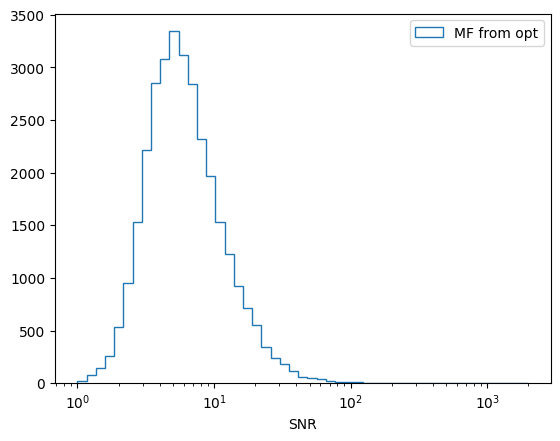

In [7]:
plt.hist(inj_data['results']['SNR_mf_from_opt_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='MF from opt');
plt.xlabel('SNR')
plt.legend()
plt.xscale('log')

In [8]:
inj_data['detected_mf_from_opt'] = get_detected_SNRs(inj_data['results'], method='two-detector', 
                                                     snr_type='mf_from_opt', network_threshold=100)

['SNR_mf_from_opt_H1', 'SNR_mf_from_opt_I1', 'SNR_mf_from_opt_L1', 'SNR_mf_from_opt_network']


### Detected percentage

In [9]:
n_total = len(inj_data['results']['redshift'])
n_detected = len(inj_data['detected_mf_from_opt']['redshift'])

print('Total =', n_total)
print('detected =', n_detected, '=', round(n_detected*100/n_total, 1), '%')

Total = 31273
detected = 16 = 0.1 %


In [10]:
inj_data['detected_mf_from_opt']

,PSD_H1,PSD_I1,PSD_L1,SNR_H1,SNR_I1,SNR_L1,SNR_mf_H1,SNR_mf_I1,SNR_mf_L1,SNR_mf_from_opt_H1,...,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,theta_jn,time_interval,trigger_time
2980,ASharp,ASharp,ASharp,68.749770,33.029451,67.340416,69.029551,32.529407,69.143694,68.188169,...,0.204441,-0.248578,0.189613,43.165907,32.540972,32.562352,75.706880,2.628393,2477.470470,1.896012e+09
3729,ASharp,ASharp,ASharp,60.974534,65.264503,81.206414,59.020410,65.264774,80.147166,62.534894,...,-0.001927,0.004706,0.001575,30.532674,26.868547,24.924198,57.401221,0.434445,1492.804800,1.896733e+09
5141,ASharp,ASharp,ASharp,53.243853,76.792019,53.340747,52.214767,76.035881,52.470786,52.773512,...,0.236339,-0.137914,-0.501259,80.441047,73.494771,66.922562,153.935818,1.985243,514.056100,1.898149e+09
9761,ASharp,ASharp,ASharp,74.956165,14.322062,63.372189,73.761181,15.303877,63.068641,75.641207,...,0.045662,0.518583,0.740123,33.286095,28.846444,26.961823,62.132539,1.089847,1914.372203,1.902833e+09
10071,ASharp,ASharp,ASharp,107.936184,42.543648,98.431688,105.773805,41.443011,98.096411,108.519679,...,-0.233910,0.610934,0.030314,29.491619,27.287299,24.692103,56.778918,2.773080,247.978690,1.903170e+09
11683,ASharp,ASharp,ASharp,63.756349,60.876777,70.533330,61.884857,60.538086,70.157610,64.257937,...,-0.374489,-0.279908,-0.465468,33.218793,24.256494,24.650793,57.475287,1.215176,2392.515012,1.904770e+09
12310,ASharp,ASharp,ASharp,69.414269,39.185697,64.530794,68.491315,39.957746,63.364378,69.779678,...,0.505143,0.071592,-0.089922,31.895611,30.518179,27.159240,62.413790,2.876751,635.657756,1.905429e+09
18547,ASharp,ASharp,ASharp,228.572675,160.132111,88.022580,229.184967,160.995251,88.661719,228.302516,...,-0.533275,-0.338310,-0.114139,40.346508,35.463000,32.915778,75.809508,1.580974,1307.934358,1.911749e+09
18635,ASharp,ASharp,ASharp,71.565333,37.405729,81.305805,70.395290,37.437474,82.276542,72.640862,...,0.103031,0.293034,0.824697,30.908794,29.642706,26.349657,60.551500,2.021814,228.768564,1.911845e+09
22204,ASharp,ASharp,ASharp,123.978490,81.453939,112.225811,124.343803,82.064248,113.515706,124.241230,...,-0.035329,-0.167992,0.096600,34.068046,31.327733,28.435166,65.395779,2.923010,3846.599254,1.915450e+09


### Choose n_events from detected as injection parameters

In [11]:
n_events = len(inj_data['detected_mf_from_opt']['redshift'])
inj_data['selected_n_events'] = inj_data['detected_mf_from_opt'].iloc[:n_events].reset_index(drop=True)

In [12]:
len(inj_data['selected_n_events']['redshift'])

16

## GWFish

In [13]:
pycbc_to_pesummary_map = {
    'mchirp': 'chirp_mass',
    'q': 'mass_ratio',
    'distance': 'luminosity_distance',
    'theta_jn': 'theta_jn',
    'ra': 'ra',
    'dec': 'dec',
    'polarization': 'psi',
    'trigger_time': 'geocent_time',
    'coa_phase': 'phase',
    'spin1_a': 'a_1',
    'spin2_a': 'a_2',
    'spin1_polar': 'tilt_1',
    'spin2_polar':'tilt_2',
    'phi_12': 'phi_12',
    'phi_jl': 'phi_jl'
}
gwfish_det_dict = {'L1':'L', 'H1':'H', 'I1':'IN'}

In [14]:
gwfish_input_data = pd.DataFrame({pycbc_to_pesummary_map[key]:inj_data['selected_n_events'][key] for key in pycbc_to_pesummary_map.keys() if key != 'q'})
gwfish_input_data['mass_ratio'] = 1/inj_data['selected_n_events']['q']

In [15]:
gwfish_input_data

,chirp_mass,luminosity_distance,theta_jn,ra,dec,psi,geocent_time,phase,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,mass_ratio
0,47.108664,2551.448280,2.628393,4.322145,0.883840,2.974579,1.896012e+09,0.743181,0.121036,0.373550,0.736447,1.038404,0.891569,2.833463,0.753858
1,33.010109,1752.897675,0.434445,3.783244,-0.276989,2.350833,1.896733e+09,1.987800,0.592146,0.005323,1.180991,1.270341,2.164845,4.976136,0.879993
2,84.088778,1338.594547,1.985243,3.911826,-0.785394,2.725428,1.898149e+09,2.925349,0.381862,0.571084,2.586043,2.641905,0.402861,5.313141,0.913648
3,34.192561,1408.229600,1.089847,4.895159,1.018387,1.080128,1.902833e+09,1.289168,0.236280,0.904873,1.238612,0.612992,0.805711,5.665937,0.866621
4,29.797285,1049.640856,2.773080,1.718538,-1.135541,1.296712,1.903170e+09,2.733542,0.389011,0.654884,2.077355,1.524491,5.985373,1.669229,0.925256
5,27.841695,627.189776,1.215176,1.294620,0.052230,1.204652,1.904770e+09,6.279988,0.100206,0.659735,2.566332,2.353977,3.907332,0.830507,0.730204
6,37.171023,2034.160446,2.876751,0.558239,1.173160,2.632715,1.905429e+09,5.843279,0.467710,0.518055,0.727340,1.745257,4.622853,3.798277,0.956814
7,34.561681,229.644301,1.580974,3.693147,-0.543764,1.406096,1.911749e+09,4.380052,0.778027,0.641765,0.725354,1.749599,0.470663,4.703462,0.878961
8,30.138606,703.054933,2.021814,4.071022,0.697420,0.508098,1.911845e+09,1.773192,0.660871,0.881255,1.756356,0.360213,4.735131,0.975397,0.959038
9,35.143239,1217.401836,2.923010,1.191531,0.475548,2.843273,1.915450e+09,2.087846,0.225685,0.196980,2.030482,1.058243,3.178270,0.131678,0.919564


In [16]:
import GWFish.modules as gwf_mods
detectors = ['A_sharp_L', 'A_sharp_H', 'A_sharp_IN']
network = gwf_mods.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.))
gwfish_snr = gwf_mods.utilities.get_snr(gwfish_input_data, network, 'IMRPhenomXPHM', f_ref=10).rename(columns={f'A_sharp_{val}':f'SNR_{key}' for key, val in gwfish_det_dict.items()}).rename(columns={'network':'SNR_network'})

In [17]:
gwfish_snr

,SNR_L1,SNR_H1,SNR_I1,SNR_network
event_0,68.810063,70.229420,40.498271,106.334877
event_1,76.965422,57.831751,60.357870,113.627726
event_2,48.076664,43.936655,66.143632,92.826588
event_3,61.057310,71.828886,26.781385,98.003196
event_4,105.682247,115.842793,62.877117,168.943250
event_5,71.011022,64.495639,52.190909,109.206885
event_6,64.971714,69.830300,42.286249,104.334660
event_7,87.380807,231.040425,108.308882,269.714474
event_8,82.454273,72.146166,15.740113,110.686619
event_9,113.806742,125.744778,81.713718,188.257418


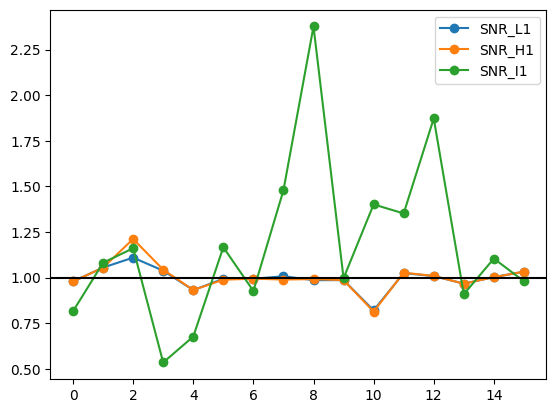

In [18]:
for key in gwfish_snr.keys():
    if 'network' in key:
        continue
    my_snr = inj_data['selected_n_events'][key]
    gwfish_snr_det = gwfish_snr[key].values
    plt.plot(my_snr/gwfish_snr_det, 'o-', label=key)
plt.legend()
plt.axhline(1, c='k')

## Bilby

In [19]:
import bilby
bilby.core.utils.log.setup_logger(log_level="warning")

In [26]:
def calc_bilby_snr(injection_parameters):
    waveform_arguments = dict(
        waveform_approximant="IMRPhenomXPHM",
        reference_frequency=10.0,
        minimum_frequency=10,
    )
    
    # Create the waveform_generator using a LAL BinaryBlackHole source function
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=64,
        sampling_frequency=4096,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=waveform_arguments,
    )
    
    ifos = bilby.gw.detector.InterferometerList(["L1", "H1", "A1"])
    ifos.set_strain_data_from_zero_noise(
        sampling_frequency=4096,
        duration=64,
        start_time=injection_parameters["geocent_time"] - 64,
    )
    
    for ifo in ifos:
        ifo.power_spectral_density = bilby.gw.detector.psd.PowerSpectralDensity(psd_file='../noise_curves/Asharp-psd.txt')
    
    ifos.inject_signal(
        waveform_generator=waveform_generator, parameters=injection_parameters
    )

    snrdict_return = {}
    optsnrsquared = 0
    for ifo in ifos:
        det = ifo.name
        SNR = ifos.meta_data[det]["optimal_SNR"]
        snrdict_return[f'SNR_{det}'] = SNR
        optsnrsquared += SNR ** 2
    snrdict_return['SNR_network'] = np.sqrt(optsnrsquared)

    return snrdict_return

In [27]:
bilby_snr = []
for event in range(len(inj_data['selected_n_events']['distance'])):
    bilby_snr.append(calc_bilby_snr({key:gwfish_input_data[key][event] for key in gwfish_input_data.keys()}))
bilby_snr = pd.DataFrame(bilby_snr).rename(columns={'SNR_A1':'SNR_I1'})
bilby_snr

,SNR_L1,SNR_H1,SNR_I1,SNR_network
0,67.579815,68.981894,33.183739,102.111183
1,75.534400,56.718430,61.014510,112.450862
2,47.080879,43.016198,54.757765,84.056025
3,59.944685,70.525759,13.115608,93.484048
4,103.645930,113.662324,44.694223,160.184819
5,69.422318,62.991946,58.200752,110.339345
6,63.763412,68.577105,38.714970,101.328382
7,85.880616,227.201330,152.047806,286.556207
8,80.880934,70.925267,37.900686,114.055167
9,111.660072,123.353728,81.048026,185.075380


## PyCBC

In [35]:
from pycbc.waveform import get_fd_waveform
from pycbc.detector import Detector
from pycbc.filter.matchedfilter import sigma

In [36]:
Detector.antenna_pattern?

Signature:
Detector.antenna_pattern(
    self,
    right_ascension,
    declination,
    polarization,
    t_gps,
    frequency=0,
    polarization_type='tensor',
)
Docstring:
Return the detector response.

Parameters
----------
right_ascension: float or numpy.ndarray
    The right ascension of the source
declination: float or numpy.ndarray
    The declination of the source
polarization: float or numpy.ndarray
    The polarization angle of the source
polarization_type: string flag: Tensor, Vector or Scalar
    The gravitational wave polarizations. Default: 'Tensor'

Returns
-------
fplus(default) or fx or fb : float or numpy.ndarray
    The plus or vector-x or breathing polarization factor for this sky location / orientation
fcross(default) or fy or fl : float or numpy.ndarray
    The cross or vector-y or longitudnal polarization factor for this sky location / orientation
File:      ~/miniconda3/envs/gwfish/lib/python3.11/site-packages/pycbc/detector/ground.py
Type:      function

In [ ]:
def calc_PyCBC_snr(params_dict):
    hp, hc = get_fd_waveform(approximant='IMRPhenomXPHM', f_lower=10, delta_f=1/16, **params_dict)
    dets = ['L1', 'H1', 'I1']
    hf = {}
    for det in dets:
        fp, fc = Detector('L1').antenna_pattern()

## Comparison plots

Text(0.5, 1.0, 'SNR network')

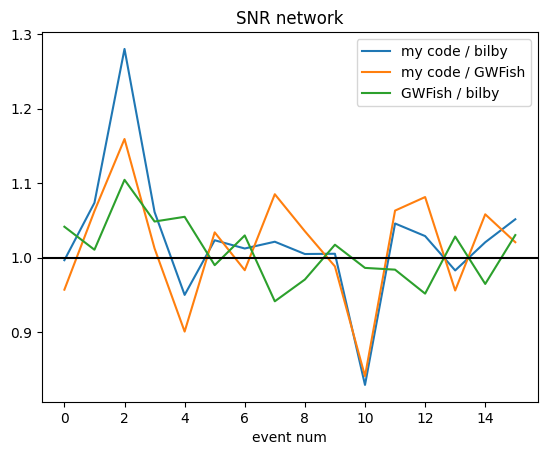

In [28]:
plt.plot(inj_data['selected_n_events']['SNR_network']/bilby_snr['SNR_network'], label='my code / bilby')
plt.plot(inj_data['selected_n_events']['SNR_network']/gwfish_snr['SNR_network'].values, label='my code / GWFish')
plt.plot(gwfish_snr['SNR_network'].values/bilby_snr['SNR_network'], label='GWFish / bilby')
plt.axhline(1, c='k')
plt.legend()
plt.xlabel('event num')
plt.title('SNR network')

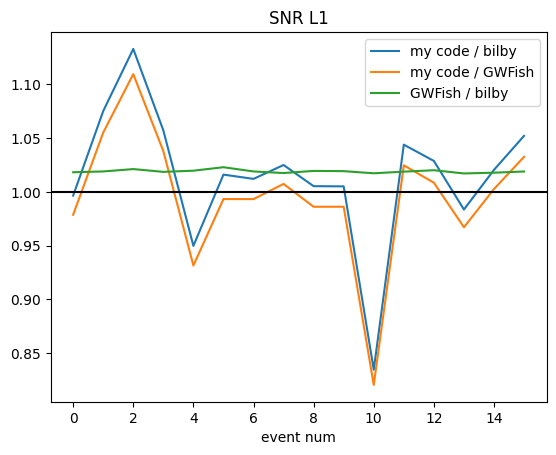

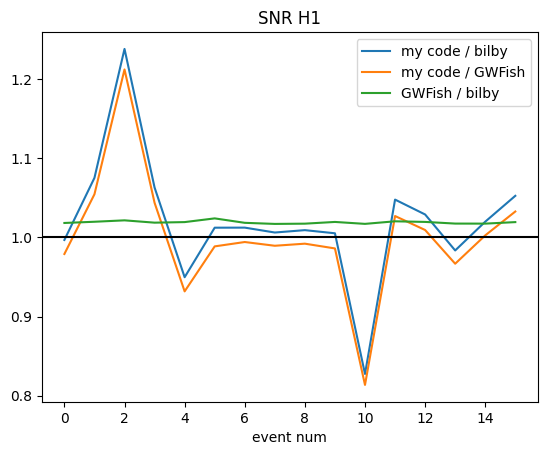

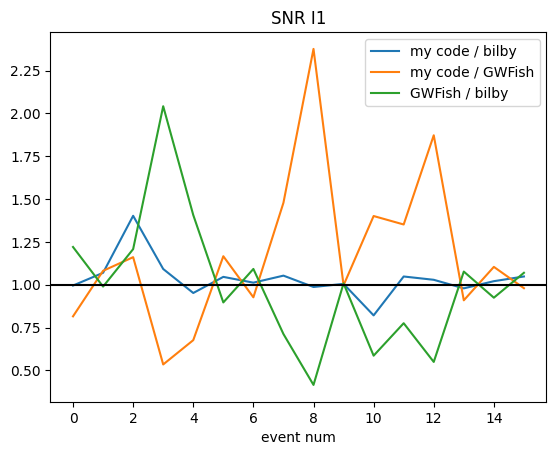

In [29]:
for det in ['L1', 'H1', 'I1']:
    plt.figure()
    plt.plot(inj_data['selected_n_events'][f'SNR_{det}']/bilby_snr[f'SNR_{det}'], label='my code / bilby')
    plt.plot(inj_data['selected_n_events'][f'SNR_{det}']/gwfish_snr[f'SNR_{det}'].values, label='my code / GWFish')
    plt.plot(gwfish_snr[f'SNR_{det}'].values/bilby_snr[f'SNR_{det}'], label='GWFish / bilby')
    plt.axhline(1, c='k')
    plt.legend()
    plt.xlabel('event num')
    plt.title(f'SNR {det}')

In [13]:
fm_params_str = 'Mc eta DL iota tc phic ra dec psi'
def run_analysis(inj_params, logging_level='WARNING', num_cores=2):
    f"""
    Parameters:
    -------------------------------------------------------------
    inj_params: dict
        dict with keys: Mc, eta, tc, phic, 
                        DL, iota, ra, dec, psi, 
                        chi1x, chi1y, chi1z, chi2x, chi2y, chi2z
    Returns:
    -----------------------
    FM: matrix
        Fisher matrix with parameter order as: {fm_params_str}
    cov: matrix
        Covariance matrix corresponding to the FM
    errors: dict
        Parameter errors
    """
    wf_model_name = 'lal_bbh'
    wf_other_var_dic = {'approximant':'IMRPhenomXPHM'}
    user_psds = {'A-Sharp':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/Asharp-asd.txt', 
                            'is_asd': True},
                 'CE40':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/CE40-asd.txt', 
                         'is_asd': True}, 
                 'CE20':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/CE20-asd.txt', 
                         'is_asd': True}, 
                 'ET10-CoBA':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/18213_ET10kmcolumns.txt', 
                              'is_asd': False}}
    user_locs = {'C1':{'longitude': -2.06175744538, 'latitude': 0.59637900541, 'arm_azimuth':0, 'which_arm':'y', 'shape':'L'}}
    conv_log = ('Mc', 'DL')
    ana_deriv_symbs_string = 'DL tc phic ra dec psi'
    network_spec = ['CE40_C1', 'CE20_CEB', 'ET10-CoBA_ET1', 'ET10-CoBA_ET2', 'ET10-CoBA_ET3']
    f_low = 5
    f_high = 1024
    df = 1/16
    f_arr = np.arange(f_low, f_high+df, df)
    net = Network(network_spec, logger_level=logging_level)
    net.set_net_vars(wf_model_name=wf_model_name, 
                     wf_other_var_dic=wf_other_var_dic,
                     f=f_arr, 
                     inj_params=inj_params,
                     deriv_symbs_string=fm_params_str,
                     ana_deriv_symbs_string=ana_deriv_symbs_string,
                     conv_log=conv_log, 
                     user_psds=user_psds,
                     user_locs=user_locs)
    net.calc_errors(derivs='num', f_lo=f_low, f_hi=f_high, num_cores=num_cores)
    return(net)

In [34]:
from pycbc.detector import Detector
d1 = Detector('C1')
d2 = Detector('V1')
print(d1.gmst_estimate(1234), d2.gmst_estimate(1234))

1.9168559938653758 1.9168559938653758
